## Demixing Components and Recovering Correlation Structure

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time, os, itertools
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append(os.getcwd())

import superpixel_analysis as sup
#import util_plot

from skimage import io

import scipy.io
from scipy.ndimage import center_of_mass, filters, gaussian_filter
from sklearn.decomposition import TruncatedSVD

import torch

## Read in movie

(112, 512, 39327)


/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


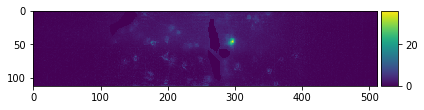

In [3]:
# input movie path
#path = '../demo_data/output';
path = '/nrs/svoboda/singha/N6/FOV6/20191214/Session1_correct_trials_raw/output'

# read in motion corrected movie
noise = np.squeeze(io.imread(path + '/Sn_image.tif'));
[nrows, ncols] = noise.shape;

if os.path.isfile(path + '/motion_corrected.tif'):
    mov = io.imread(path + '/motion_corrected.tif').transpose(1,2,0);
elif os.path.isfile(path + '/denoised.tif'):
    mov = io.imread(path + '/denoised.tif');
else:
    raise ValueError('No valid input file');

# read in the mask for blood
if os.path.isfile(path + '/bloodmask.tif'):
    bloodmask = np.squeeze(io.imread(path + '/bloodmask.tif'));
    mov = mov * np.repeat(np.expand_dims(noise * bloodmask,2),mov.shape[2],axis=2);
else:
    mov = mov * np.repeat(np.expand_dims(noise,2),mov.shape[2],axis=2);

# display average movie
print(mov.shape);
io.imshow(np.std(mov,axis=2));

## Spatial 2x2 Binning

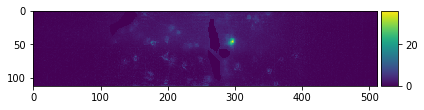

In [4]:
movB = mov.reshape(int(mov.shape[0]/2),2,int(mov.shape[1]/2),2,mov.shape[2]);
movB = np.mean(np.mean(movB,axis=1),axis=2);
movB.shape

movB = mov;
# show standard deviation image of binned movie
io.imshow(np.std(movB,axis=2))

## Load Manually Initialized Background

In [5]:
bg_flag = os.path.isfile(path + '/ff.tif');

if bg_flag:
    # import manually initialized background components
    ff_ini = io.imread(path + '/ff.tif')
    fb_ini = io.imread(path + '/fb.tif')

    # bin the spatial components
    fb_ini = fb_ini.reshape(mov.shape[1],mov.shape[0],-1).transpose(1,0,2)
#     fb_ini = fb_ini.reshape(int(fb_ini.shape[0]/2),2,int(fb_ini.shape[1]/2),2,fb_ini.shape[2])
#     fb_ini = np.mean(np.mean(fb_ini,axis=1),axis=2)

    fb_ini.shape

    # plot manually initialized background components
    plt.figure(figsize=(30,20))

    for i in range(6):
        plt.subplot(3,4,2*i+1)
        plt.plot(ff_ini[:2000,i])
        plt.subplot(3,4,2*i+2)
        io.imshow(fb_ini[:,:,i])

In [6]:
if bg_flag:
    # select which background components to use for initialization
    bkg_components = range(3)

    fb_ini = fb_ini[:,:,bkg_components].reshape(movB.shape[0]*movB.shape[1],len(bkg_components))
    ff_ini = ff_ini[:,bkg_components]

## Get Cell Spatial Supports from High Pass Filtered Movie

In [7]:
start = time.time()

# select which window to demix on
first_frame = 1
last_frame = 5000

movHP = sup.hp_filt_data(movB,spacing=10)

rlt=sup.axon_pipeline_Y(movHP[:,:,first_frame:last_frame].copy(), fb_ini = np.zeros(1), ff_ini = np.zeros(1),
                        
                        ##### Superpixel parameters
                        # thresholding level
                        th = [4],
                        
                        # correlation threshold for finding superpixels
                        # (range around 0.8-0.99)
                        cut_off_point = [0.95], 
                        
                        # minimum pixel count of a superpixel
                        # don't need to change these unless cell sizes change
                        length_cut = [10],
                        
                        # maximum pixel count of a superpixel
                        # don't need to change these unless cell sizes change
                        length_max = [1000], 
                       
                        patch_size = [30,30], 
                        
                        # correlation threshold between superpixels for merging
                        # likely don't need to change this
                        residual_cut = [np.sqrt(1-(0.8)**2)],
                        
                        pass_num = 1, bg = False, 
                        
                        ##### Cell-finding, NMF parameters
                        # correlation threshold of pixel with superpixel trace to include pixel in cell
                        # (range 0.3-0.6)
                        corr_th_fix = 0.4,
                        
                        # correlation threshold for merging two cells
                        # (default 0.8, but likely don't need to change)
                        merge_corr_thr = 0.8, 
                        
                        ##### Other options
                        # if True, only superpixel analysis run; if False, NMF is also run to find cells
                        sup_only = False,
                        
                        # the number of superpixels to remove (starting from the dimmest)
                        remove = 0
                       )

print("Demixing took: " + str(time.time()-start)+" sec")

start 1 pass!
find superpixels!


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:299: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Yt.transpose(2,0,1) - np.mean(Yt, axis=2)) / np.std(Yt, axis=2);


10.391592979431152
rank 1 svd!
2.1944215297698975
find pure superpixels!
0.21753883361816406
prepare iteration!
1.8735179901123047
14.83447813987732
start 1 pass iteration!
a.shape = (57344, 51); c.shape = (4999, 51)


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2237: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);


time: 2.502558469772339
time: 2.4552183151245117
time: 2.366529941558838


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 5.096187353134155
time: 2.39315128326416
time: 2.3872158527374268
time: 2.7231624126434326


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

merge[11 16]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);


merge[42 36 50]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:767: RuntimeWarning: invalid value encountered in greater
  labeled_array, num_features = scipy.ndimage.measurements.label(corr_img_all_r[:,:,kk,ii] > corr,structure=s);


corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 10.23786735534668
time: 2.234501838684082
time: 2.4872655868530273
time: 2.5480735301971436


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

merge[37 47]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);


merge[49 42]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:767: RuntimeWarning: invalid value encountered in greater
  labeled_array, num_features = scipy.ndimage.measurements.label(corr_img_all_r[:,:,kk,ii] > corr,structure=s);


corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 9.606813430786133
time: 2.25592041015625
time: 2.2660670280456543
time: 2.456146240234375


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


merge[48 18]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:767: RuntimeWarning: invalid value encountered in greater
  labeled_array, num_features = scipy.ndimage.measurements.label(corr_img_all_r[:,:,kk,ii] > corr,structure=s);


corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 8.127132177352905
time: 2.2980384826660156
time: 2.6315925121307373
time: 2.3188185691833496


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

merge[11 48]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:767: RuntimeWarning: invalid value encountered in greater
  labeled_array, num_features = scipy.ndimage.measurements.label(corr_img_all_r[:,:,kk,ii] > corr,structure=s);


corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 7.540441989898682
time: 2.2397003173828125
time: 2.4793810844421387
time: 2.2729036808013916


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 4.865759611129761
time: 2.2460248470306396
time: 2.24290132522583
time: 2.292989730834961


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 5.173127889633179
time: 2.2740213871002197
time: 2.2122738361358643
time: 2.4999186992645264


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 4.936797380447388
time: 2.760859966278076
time: 2.6262025833129883
time: 2.231452226638794


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2180: RuntimeWarning: invalid value encountered in greater
  cri = np.asarray((cor_corr/(temp.T)) > merge_overlap_thr)*np.asarray((cor_corr/temp) > merge_overlap_thr)*((a_corr>0).toarray());#.toarray())*(((cor_corr/(temp.T)) > merge_overlap_thr).toarray())*((a_corr > 0).toarray());
/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6

no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 4.815638303756714
time: 2.2043986320495605
time: 2.242194652557373
time: 2.393644332885742


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


merge[43 45]


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2216: RuntimeWarning: invalid value encountered in true_divide
  corr_temp = vcorrcoef_Y(U/normalize_factor, c_temp);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:767: RuntimeWarning: invalid value encountered in greater
  labeled_array, num_features = scipy.ndimage.measurements.label(corr_img_all_r[:,:,kk,ii] > corr,structure=s);


corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 7.4622814655303955
time: 2.2361667156219482
time: 2.2687430381774902
time: 2.2123966217041016


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 4.875229358673096
time: 2.2328732013702393
time: 2.227189064025879
time: 2.5639076232910156


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
corr too low!
time: 4.980720520019531
time: 2.2371633052825928
time: 2.2299177646636963
171.91260290145874
Demixing took: 248.7427351474762 sec


/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


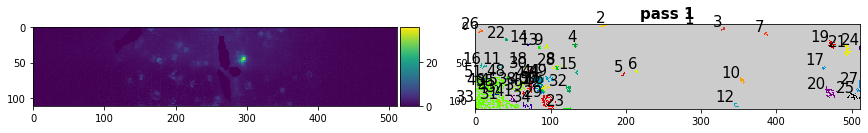

In [8]:
# plot pure superpixels

num_pass = len(rlt["superpixel_rlt"])
    
scale = np.maximum(1, (rlt["superpixel_rlt"][0]["connect_mat_1"].shape[1]/rlt["superpixel_rlt"][0]["connect_mat_1"].shape[0]));
fig = plt.figure(figsize=(4*scale*num_pass,4))

plt.subplot(1,num_pass+2,1);
io.imshow(np.std(movB,axis=2));

for p in range(num_pass):
    connect_mat_1 = rlt["superpixel_rlt"][p]["connect_mat_1"]
    pure_pix = rlt["superpixel_rlt"][p]["pure_pix"]
    brightness_rank = rlt["superpixel_rlt"][p]["brightness_rank"]
    ax1 = plt.subplot(1,num_pass+2,p+2);
    dims = connect_mat_1.shape;
    connect_mat_1_pure = connect_mat_1.copy();
    connect_mat_1_pure = connect_mat_1_pure.reshape(np.prod(dims),order="F");
    connect_mat_1_pure[~np.in1d(connect_mat_1_pure,pure_pix)]=0;
    connect_mat_1_pure = connect_mat_1_pure.reshape(dims,order="F");

    ax1.imshow(connect_mat_1_pure,cmap="nipy_spectral_r");

    for ii in range(len(pure_pix)):
        pos = np.where(connect_mat_1_pure[:,:] == pure_pix[ii]);
        pos0 = pos[0];
        pos1 = pos[1];
        ax1.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)], f"{brightness_rank[ii]+1}",
            verticalalignment='bottom', horizontalalignment='right',color='black', fontsize=15)#, fontweight="bold")
    
    ax1.set(title="pass " + str(p+1))
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold");
    plt.tight_layout();

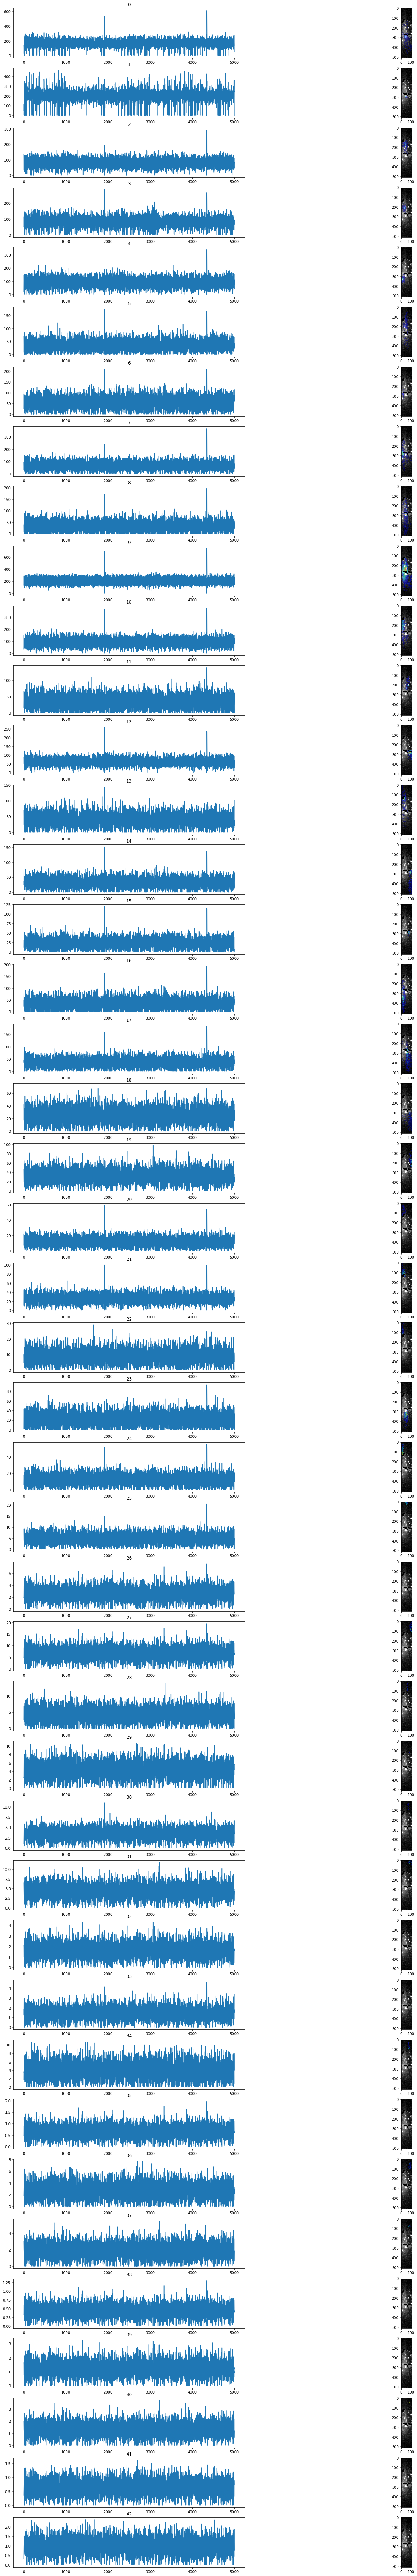

In [9]:
# plot all cell traces and footprints from NMF
cell_ct = rlt["fin_rlt"]["c"].shape[1]

plt.figure(figsize=(25,3*cell_ct))
    
ref_im = np.std(movB,axis=2).transpose(1,0)

for cell_num in range(cell_ct):
    plt.subplot(cell_ct,2,2*cell_num+1)
    plt.plot(rlt["fin_rlt"]["c"][:,cell_num])
    plt.title(cell_num)
    
    plt.subplot(cell_ct,2,2*cell_num+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = rlt["fin_rlt"]["a"][:,cell_num].reshape(movB.shape[1],movB.shape[0])#.transpose(1,0)
    cell_loc = np.ma.masked_where(cell_loc == 0, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)

In [10]:
proc = input('Ok to proceed? (y/n) ')

if proc.lower() == 'n':
    raise KeyboardInterrupt('Stop requested by user.')

Ok to proceed? (y/n) y


## Get Background Components from Unfiltered Movie

In [10]:
# rank of background to model, if none selected
bg_rank = 3;
final_cells = [0,1,3,5,7]

nCells = len(final_cells)

a = rlt["fin_rlt"]["a"][:,final_cells].copy();
c = rlt["fin_rlt"]["c"][:,final_cells].copy();
b = rlt["fin_rlt"]["b"].copy();

dims = movB.shape[:2];
T = last_frame - first_frame;

movVec = movB.reshape(np.prod(dims),-1,order="F");
mov_min = movVec.min();
if mov_min < 0:
    mov_min_pw = movVec.min(axis=1,keepdims=True);
    movVec -= mov_min_pw;

normalize_factor = np.std(movVec,axis=1,keepdims=True)*T
    
if bg_flag:
    fb = fb_ini;
    ff = ff_ini[first_frame:last_frame,:];
    bg_rank = fb.shape[1]
else:
    bg_comp_pos = np.where(a.sum(axis=1) == 0)[0];
    y_temp = movVec[bg_comp_pos,first_frame:last_frame];
    fb = np.zeros([movVec.shape[0],bg_rank]);
    y_temp = y_temp - y_temp.mean(axis=1,keepdims=True);
    svd = TruncatedSVD(n_components=bg_rank,n_iter=7,random_state=0);
    fb[bg_comp_pos,:] = svd.fit_transform(y_temp);
    ff = svd.components_.T;
    ff = ff - ff.mean(axis=0,keepdims=True)

a, c, b, fb, ff, res, \
corr_img_all_r, num_list = \
sup.update_AC_bg_l2_Y(movVec[:,first_frame:last_frame].copy(),normalize_factor, a, c, b, ff, fb, dims,
                      corr_th_fix=0.35,
                      maxiter=35, tol=1e-8,
                      merge_corr_thr=0.8,
                      merge_overlap_thr=0.8, keep_shape=True
                     );


/groups/svoboda/home/singha/invivo-imaging/demix/superpixel_analysis.py:2319: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);


time: 2.2083568572998047
time: 2.185694456100464
time: 2.1912763118743896
time: 2.168496608734131
time: 2.1678292751312256
time: 2.153140068054199
time: 2.17972731590271
time: 2.192354202270508
time: 2.220963716506958
time: 2.183171033859253
time: 2.165397882461548
time: 2.522721529006958
time: 2.19539213180542
time: 2.493983268737793
time: 2.2000479698181152
time: 2.513103485107422
time: 2.4172511100769043
time: 2.1687190532684326
time: 2.1585185527801514
time: 2.1710011959075928
time: 2.4652934074401855
time: 2.5427560806274414
time: 2.172980546951294
time: 2.18886137008667
time: 2.1829216480255127
time: 2.1565866470336914
time: 2.3874764442443848
time: 2.2090885639190674
time: 2.1499452590942383
time: 2.1494319438934326
time: 2.1669790744781494
time: 2.1827735900878906
time: 2.1867048740386963
time: 2.136730432510376
time: 2.203355550765991


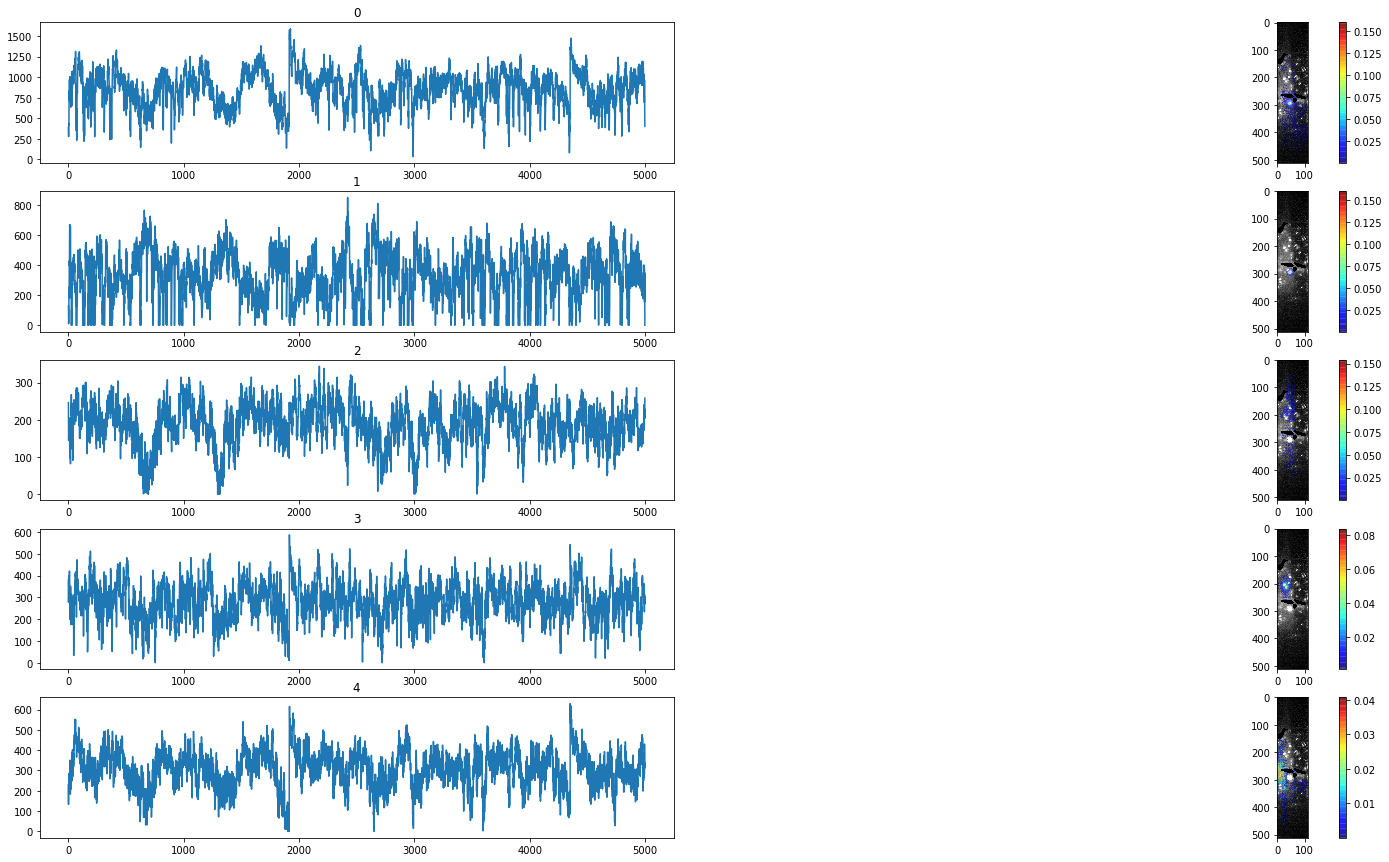

In [11]:
# plot all cell traces and footprints
cell_ct = c.shape[1]

plt.figure(figsize=(25,3*cell_ct))
    
ref_im = np.std(movB,axis=2).transpose(1,0)

for cell_num in range(cell_ct):
    plt.subplot(cell_ct,2,2*cell_num+1)
    plt.plot(c[:,cell_num])
    plt.title(cell_num)
    
    plt.subplot(cell_ct,2,2*cell_num+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = a[:,cell_num].reshape(movB.shape[1],movB.shape[0])#.transpose(1,0)
    cell_loc = np.ma.masked_where(cell_loc == 0, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)
    plt.colorbar();

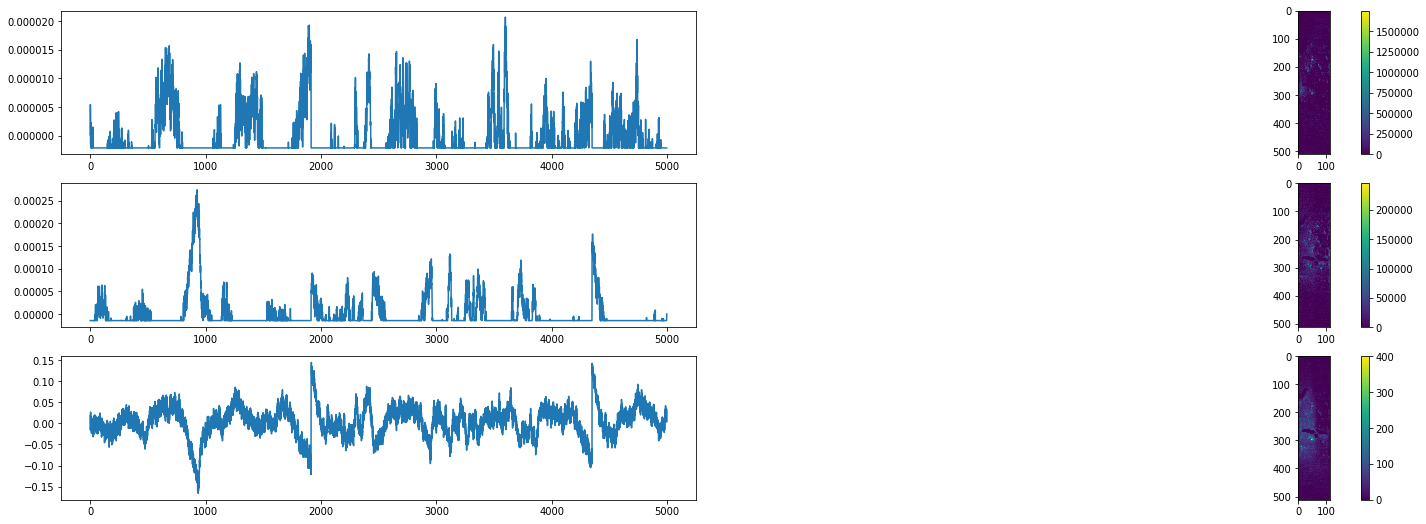

In [12]:
# plot all background traces and footprints
bg_rank = fb.shape[1]

plt.figure(figsize=(25,3*bg_rank))

for bkgd_num in range(bg_rank):
    plt.subplot(bg_rank,2,2*bkgd_num+1)
    plt.plot(ff[:,bkgd_num])
    
    bkgd_comp = fb[:,bkgd_num].reshape(movB.shape[1::-1])#.transpose(1,0)
    plt.subplot(bg_rank,2,2*bkgd_num+2)
    plt.imshow(bkgd_comp);
    plt.colorbar();

In [13]:
proc = input('Ok to proceed? (y/n) ')

if proc.lower() == 'n':
    raise KeyboardInterrupt('Stop requested by user.')

Ok to proceed? (y/n) y


## Choose Cells and Recover Temporal Correlation Structures

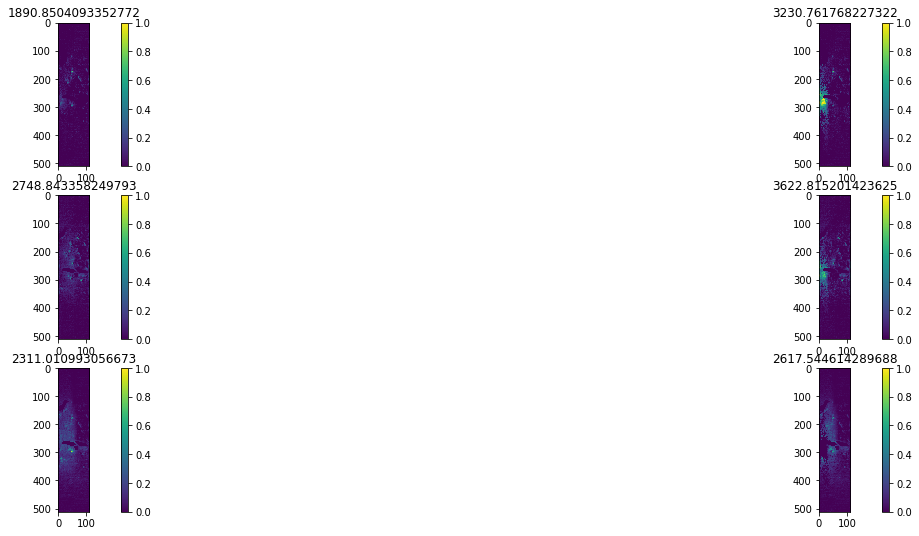

In [14]:
def tv_norm(image):
    return np.sum (np.abs(image[:,:-1] - image[:,1:])) + np.sum(np.abs(image[:-1,:] - image[1:,:]))

Y = movB.transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])
X = np.hstack((a, fb))
X = X / np.ptp(X,axis=0);
X2 = np.zeros((X.shape[0],nCells + bg_rank))
X2[:,:nCells] = X[:,:nCells]

plt.figure(figsize=(25,3*bg_rank))
plt.title('New Background Components')

lr = 0.001;
maxIters = 1000;

for b in range(bg_rank):
    bg_im = X[:,-(b+1)].reshape(movB.shape[-2::-1]);
    
    plt.subplot(bg_rank,2,(bg_rank-b)*2-1)
    plt.imshow(bg_im);
    plt.title(str(tv_norm(bg_im)))
    plt.colorbar();
    
    weights = torch.zeros((nCells,1),requires_grad=True,dtype=torch.double);
    
    image = torch.from_numpy(bg_im);
    
    for idx in range(maxIters):
        test_im = image-torch.reshape(torch.from_numpy(X[:,:nCells]) @ weights,movB.shape[-2::-1]);
        tv = torch.sum(torch.abs(test_im[:,:-1] - test_im[:,1:])) + torch.sum(torch.abs(test_im[:-1,:] - test_im[1:,:]))
        
        tv.backward();
        
        with torch.no_grad():
            weights -= lr * weights.grad;
            
        weights.grad.zero_();

    opt_weights = weights.data.numpy();
    
    X2[:,-(b+1)] = np.maximum(X[:,-(b+1)]-np.squeeze(X[:,:nCells] @ opt_weights),0);

    plt.subplot(bg_rank,2,(bg_rank-b)*2)
    plt.imshow(X2[:,-(b+1)].reshape(movB.shape[-2::-1]),vmin=0,vmax=1);
    plt.title(str(tv_norm(X2[:,-(b+1)].reshape(movB.shape[-2::-1]).T)))
    plt.colorbar();

## Reload Trend (Skip if not using Optopatch Stim)

In [19]:
proc = input('Do you want to load a trend? (y/n) ');

if proc.lower() == 'y':
    trend = io.imread(path + '/trend.tif')
    plt.imshow(np.mean(trend,axis=2))
    trendB = trend.reshape(int(trend.shape[0]/2),2,int(trend.shape[1]/2),2,trend.shape[2])
    trendB = np.mean(np.mean(trendB,axis=1),axis=2)
    trendB.shape

    Y = (movB+trendB).transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])
    print('Trend reloaded!')

Do you want to load a trend? (y/n)  n


## Get Final Traces

In [15]:
beta_hat2 = np.linalg.lstsq(X2, Y)[0]
res = np.mean(np.square(Y - X2 @ beta_hat2),axis = 0)

/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


## Visualizations

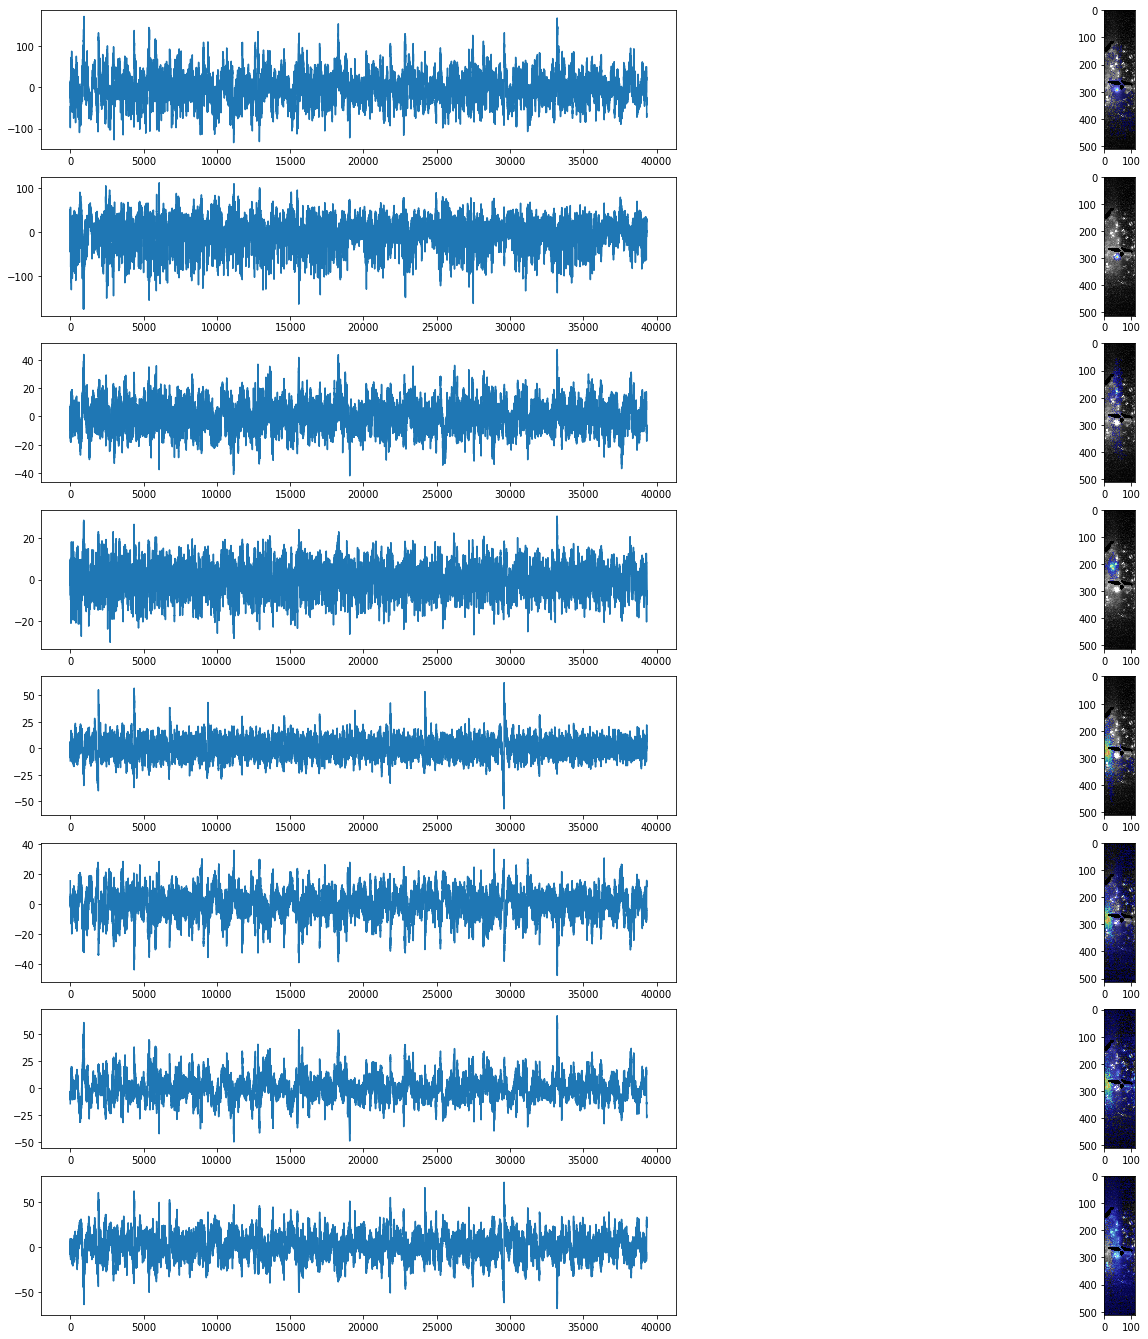

In [16]:
num_traces = beta_hat2.shape[0]
plt.figure(figsize=(25,3*num_traces))
ref_im = np.std(movB,axis=2).transpose(1,0)

for idx in range(num_traces):
    plt.subplot(num_traces,2,2*idx+1)
    plt.plot(beta_hat2[idx,:])
    
    plt.subplot(num_traces,2,2*idx+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = X2[:,idx].reshape(movB.shape[1::-1])#.transpose(1,0)
    cell_loc = np.ma.masked_where(abs(cell_loc) < 1e-8, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)

## Save Results

In [17]:
proc = input('Do you want to save out results? (y/n) ');

if proc.lower() == 'y':
    suffix = ''

    io.imsave(path + '/spatial_footprints'+suffix+'.tif', X2)
    io.imsave(path + '/cell_spatial_footprints'+suffix+'.tif', X2[:,:nCells])
    io.imsave(path + '/temporal_traces'+suffix+'.tif', beta_hat2)
    io.imsave(path + '/cell_traces'+suffix+'.tif', beta_hat2[:nCells,:])
    io.imsave(path + '/residual_var'+suffix+'.tif', res)

    cell_locations = center_of_mass(X2[:,0].reshape(movB.shape[1::-1]).transpose(1,0))
    for idx in range(nCells - 1):
        cell_locations = np.vstack((cell_locations, 
                                    center_of_mass(X2[:, idx + 1].reshape(movB.shape[1::-1]).transpose(1,0))))
    io.imsave(path + '/cell_locations'+suffix+'.tif', np.array(cell_locations))

    if nCells > 1:
        io.imsave(path + '/cell_demixing_matrix'+suffix+'.tif', 
                  np.linalg.inv(np.array(X2[:,:nCells].T @ X2[:,:nCells])) @ X2[:,:nCells].T)
    print('Saved!')

Do you want to save out results? (y/n) y
Saved!


/groups/svoboda/home/singha/anaconda2/envs/invivo/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: /nrs/svoboda/singha/N6/FOV6/20191214/Session1_correct_trials_raw/output/cell_demixing_matrix.tif is a low contrast image
